# Sales Forecasting Training

## Preliminary
We will try to find out the methods to get in Sales forecasting. For this training, we will use data from `Kaggle` with the details : <br>
<https://www.kaggle.com/c/demand-forecasting-kernels-only>
<br> with the name of competition is `Store Item Demand Forecasting Challenge`. THey want us to predict 3 months of item sales at different stores. Let's try em' all.
<br> For the first time, we will Sarimax.

## Season I
This kernel is what I wrote method of time series analysis that I know.

The order of explain is as follows.
1. Overview of the data
2. Model choice
3. Correlograms
4. ARIMA
5. SARIMA
6. Make featrues - Phase 1
7. ARIMAX
8. SARIMAX
9. Model's summary check
10. Make featrues - Phase 2
11. Search best parameters
12. Submit Prediction 

### Modul Import

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import datetime as dtz

In [2]:
Compile_date = dtz.datetime.now()
print('The last date we try to compile this code at :',Compile_date)

The last date we try to compile this code at : 2019-12-02 11:04:55.049668


In [3]:
# Make pandas display in scientific format for all continuous computing
pd.options.display.float_format = '{:.0f}'.format

### Data Preparation

In [4]:
Train = pd.read_csv('../KAGGLE_SAMPLE/DATA/train.csv', parse_dates=['date'], index_col='date')
Test = pd.read_csv('../KAGGLE_SAMPLE/DATA/test.csv', parse_dates=['date'], index_col='date')

We will 'merge' the Train and Test data using Concat. So the data in specific data will be in along side of dataset.

In [5]:
dfmy = pd.concat([Train, Test])

### Overview of Data

In [6]:
display(dfmy.describe())
display(dfmy.head(5))
print('Type of Data in each columns :')
display(dfmy.dtypes)
print('The number of NaN in data :')
display(dfmy.isna().sum())

,id,item,sales,store
count,45000,958000,913000,958000
mean,22500,26,52,6
std,12991,14,29,3
min,0,1,0,1
25%,11250,13,30,3
50%,22500,26,47,6
75%,33749,38,70,8
max,44999,50,231,10


,id,item,sales,store
date,,,,
2013-01-01,nan,1,13,1
2013-01-02,nan,1,11,1
2013-01-03,nan,1,14,1
2013-01-04,nan,1,13,1
2013-01-05,nan,1,10,1


Type of Data in each columns :


id       float64
item       int64
sales    float64
store      int64
dtype: object

The number of NaN in data :


id       913000
item          0
sales     45000
store         0
dtype: int64

In [7]:
x2 = list(set((Train.columns.values).tolist())-set(['date']))
x3 = []
x4 = []
for i in range(len(x2)) :
    x1 = Train[x2[i]].unique().tolist()
    x3.append(len(x1))
    x4.append(Train[x2[i]].isnull().sum())
Num_Uniq = pd.DataFrame({'Feature':x2,'Num_Unique':x3,'Missing_Value':x4})
print('Statistics description of Number of unique category in Features :')
display(Num_Uniq.describe())
display(Num_Uniq.describe(include='O'))
display(Num_Uniq['Feature'].value_counts())

Statistics description of Number of unique category in Features :


,Missing_Value,Num_Unique
count,3,3
mean,0,91
std,0,108
min,0,10
25%,0,30
50%,0,50
75%,0,132
max,0,213


,Feature
count,3
unique,3
top,store
freq,1


store    1
sales    1
item     1
Name: Feature, dtype: int64

Let's see overview of the data. We can use seasonal_decompose method to separate into four graphs(Observed,Trend,Seasonal,Residual).  
What is seasonal_decompose method parameter 'freq'?
- freq = 365 days : trend of year.  
- freq = 30 days : trend of month.  
- freq = 7 days : trend of week.  

We choose 'freq=365' ,because this data is long term.


Frequency 365


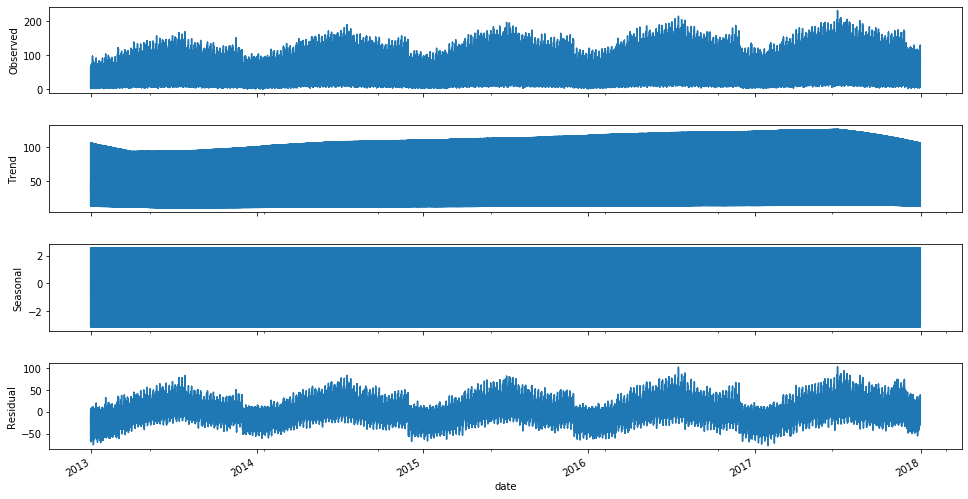

_______________________________________________________________________________________________________________________________________________________________________________

Frequency 30


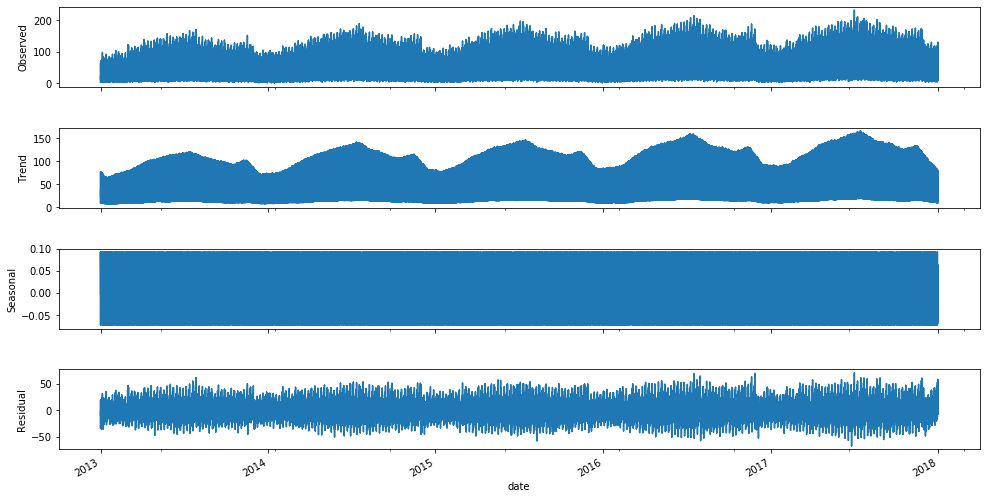

_______________________________________________________________________________________________________________________________________________________________________________

Frequency 7


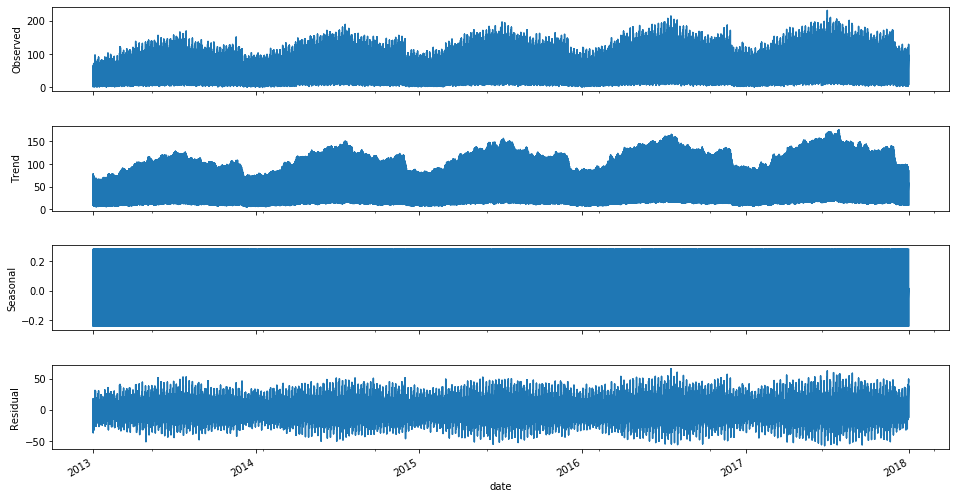

_______________________________________________________________________________________________________________________________________________________________________________


In [8]:
season = [365, 30, 7]
for alp in season :
    print('\nFrequency',alp)
    res = sm.tsa.seasonal_decompose(Train.sales.dropna(),freq=alp)
    fig = res.plot()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()
    print('_'*175)

In [9]:
print("Let's check the Pivoting or Value count")
print(Train['store'].value_counts())
print("_"*75)
print(Train['item'].value_counts())
print("_"*75)
print(Train['sales'].value_counts())

Let's check the Pivoting or Value count
10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64
___________________________________________________________________________
50    18260
13    18260
23    18260
22    18260
21    18260
20    18260
19    18260
18    18260
17    18260
16    18260
15    18260
14    18260
12    18260
49    18260
11    18260
10    18260
9     18260
8     18260
7     18260
6     18260
5     18260
4     18260
3     18260
2     18260
24    18260
25    18260
26    18260
27    18260
48    18260
47    18260
46    18260
45    18260
44    18260
43    18260
42    18260
41    18260
40    18260
39    18260
38    18260
37    18260
36    18260
35    18260
34    18260
33    18260
32    18260
31    18260
30    18260
29    18260
28    18260
1     18260
Name: item, dtype: int64
___________________________________________________________________________
30     14283
27     14231
26     1421

### Sampling for Model in General
We try to use the the model for Store 1 and items 1 only

In [10]:
DF01 = dfmy[(dfmy.item==1)&(dfmy.store==1)].copy()
DF01.head()

,id,item,sales,store
date,,,,
2013-01-01,nan,1,13,1
2013-01-02,nan,1,11,1
2013-01-03,nan,1,14,1
2013-01-04,nan,1,13,1
2013-01-05,nan,1,10,1


In [11]:
#Train and Split again for the Data
tr_start,tr_end = '2015-01-01','2017-09-30' #training boundary date
te_start,te_end = '2017-10-01','2017-12-31' #test boundary date
TRAIN01 = dfmy['sales'][tr_start:tr_end].dropna() #We try to make training data again came from start time dan date time
TEST01 = dfmy['sales'][te_start:te_end].dropna() #Make test data from the boundary train

In [12]:
TRAIN01.dtype

dtype('float64')

### Model Choice
each models have parameters.
- ARMA model:(p,q)
- ARIMA model:(p,d,q)
- SARIMA model:(p,d,q)(sp,sd,sq,s)
- ARIMAX model:(p,d,q) + exog
- SARIMAX model:(p,d,q)(sp,sd,sq,s) + exog

We have to choice a model, *After we comfirm that a data has a trend(is stationary) or not.*
<br/>For example, ARMA model is premised that the data is stationary.
We can use ADF-test to check stationary of the data.
<br/>It's important to choose carefully a period of the data which will be used in predicting. **Because, The results depend on the period.**

In [13]:
#ADF-test(Original-time-series) for the Train Data
'''
an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present 
in a time series sample. The alternative hypothesis is different depending on which version 
of the test is used, but is usually stationarity or trend-stationarity. It is an augmented 
version of the Dickey–Fuller test for a larger and more complicated set of time series models.
* The null hypothesis is NOT rejected as the p-value is greater than 0.05.
* A time series Y_t (t=1,2...) is said to be stationary (in the weak sense) if its statistical 
properties do not vary with time (expectation, variance, autocorrelation). The white noise is 
an example of a stationary time series, with for example the case where Y_t follows a normal 
distribution N(mu, sigma^2) independent of t.
'''
print('Null hypothesis is series possesses a unit root and hence is not stationary.')
adft1 = sm.tsa.adfuller(DF01['sales'].dropna(),regression='ct') #drop the NA row, and do regression for constant and trend
print('We got p-value:{}'.format(adft1[1]))
if adft1[1] < .05 :
    print('So, we rejected the Null hypothesis')
else: print('The Null hypthosis is not rejected')

Null hypothesis is series possesses a unit root and hence is not stationary.
We got p-value:0.0761068899241545
The Null hypthosis is not rejected


In [14]:
#ADF-test(differenced-time-series) for the Train Data
print('Null hypothesis is series possesses a unit root and hence is not stationary.')
adft2 = sm.tsa.adfuller(DF01['sales'].diff().dropna(),regression='c') #drop the NA row, and do regression for constant only
print('We got p-value:{}'.format(adft2[1]))
if adft2[1] < .05 :
    print('So, we rejected the Null hypothesis')
else: print('The Null hypthosis is not rejected')

Null hypothesis is series possesses a unit root and hence is not stationary.
We got p-value:1.2109276320440464e-23
So, we rejected the Null hypothesis


In [15]:
#ADF-test(differenced-time-series) for the Train Data, truncated at year 2015
print('Null hypothesis is series possesses a unit root and hence is not stationary.')
adft3 = sm.tsa.adfuller(DF01['sales']['2015-01-01':].dropna(),regression='ct') #drop the NA row, and do regression for constant and trend
print('We got p-value:{}'.format(adft3[1]))
if adft3[1] < .05 :
    print('So, we rejected the Null hypothesis')
else: print('The Null hypthosis is not rejected')

Null hypothesis is series possesses a unit root and hence is not stationary.
We got p-value:0.5620643402531433
The Null hypthosis is not rejected


In [16]:
#ADF-test(differenced-time-series) for the Train Data, truncated at year 2015
print('Null hypothesis is series possesses a unit root and hence is not stationary.')
#diff() : Calculates the difference of a DataFrame element compared with another element in the DataFrame 
#(default is the element in the same column of the previous row)
adft4 = sm.tsa.adfuller(DF01['sales']['2015-01-01':].diff().dropna(),regression='c') #drop the NA row, and do regression for constant only
print('We got p-value:{}'.format(adft4[1]))
if adft4[1] < .05 :
    print('So, we rejected the Null hypothesis')
else: print('The Null hypthosis is not rejected')

Null hypothesis is series possesses a unit root and hence is not stationary.
We got p-value:4.530417561582162e-22
So, we rejected the Null hypothesis


It's important to choose carefully a period of the data which will be used in predicting. Because, The results depend on the period.

What is adfuller method parameter 'regression'?
- c : constant only (default)
- ct : constant and trend
- ctt : constant, and linear and quadratic trend
- nc : no constant, no trend

[ADFuller Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) 

Usually, We try to testing both data Original and Diff.<br/>  
Like the results above, When Original-data is not stationary and Diff-data is stationary,
<br/>the time series is called unit root process. 
<br/>For unit root process, We use ARIMA or SARIMA model.
<br/>From results,We decided that Original time series is not stational.    
<br/>We will try to using ARIMA model.

### Correlograms
Autocorrelogram & Partail Autocorrelogram is useful that to estimate each models parameters.

In the analysis of data, a correlogram is an image of correlation statistics. For example, in time series analysis, a correlogram, also known as an autocorrelation plot, is a plot of the sample autocorrelations r_{h} versus h (the time lags).

If cross-correlation is used, the result is called a cross-correlogram. The correlogram is a commonly used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

In addition, correlograms are used in the model identification stage for Box–Jenkins autoregressive moving average time series models. Autocorrelations should be near-zero for randomness; if the analyst does not check for randomness, then the validity of many of the statistical conclusions becomes suspect. The correlogram is an excellent way of checking for such randomness.

Most of us know how to use ACF and PACF plots to obtain the values of p and q to feed into the AR-I-MA model, but we lack the intuition behind why we use PACF and ACF to obtain p and q respectively and not the other way around. ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a 'complete auto-correlation plot'.

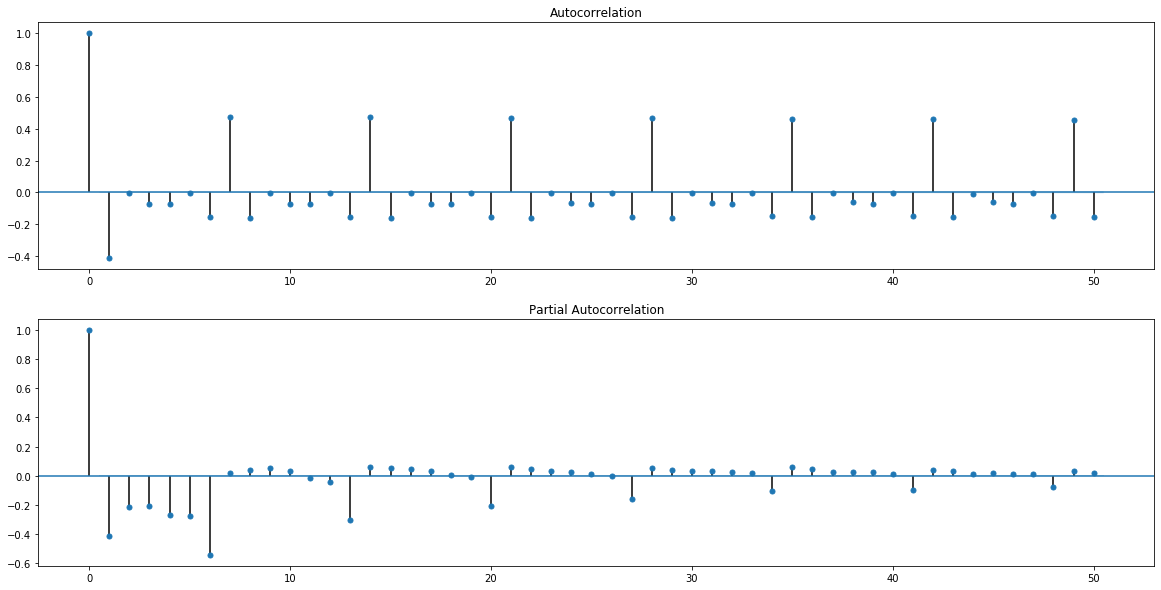

In [17]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(TRAIN01.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(TRAIN01.diff().dropna(), lags=50, ax=ax[1])
fig.show()

That you see in the ACF plot, for the lag 0 has correlation 1 because it's compared by itself. Lag 1 has correlation -0.4. Till lag 7, we have the first hight as 0.5 for the correlation. The cutoff is 0.5 and -0.5. We could say p is a lag time series from Autoregressive, so p is 7. We get first lowest lag in lag 6 for PACF, we said the integratation between AR & MA is 7-6 = 1 as i. 

The ACF plot you provided may suggest an MA(2). I would guess that you have some significant AR orders just looking at the sinusoidal decay in auto-correlation. But all this is extremely speculative since the coefficients become insignificant very quickly as lag increases. Seeing the PACF would be very helpful.

Another important thing you want to watch for is significance in the 4th lag on the PACF. Since you have quarterly data, significance in the 4th lag is a sign of seasonality. For example if your investment is a gift store, returns may higher during the holidays (Q4) and lower during the beginning of the year (Q1), causing correlation between identical quarters.

The significant coefficients for smaller lags in the ACF plot should stay the same as your data size increases assuming nothing changes with the investment. Higher lags are estimated with less data points then are lower lags (i.e every lag looses a data point), so you can use the sample size in the estimation of each lag to guide your judgment as to which will stay the same and which are less reliable.

However, if you want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. More on the ACF in the upcoming sections. But when there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

how to compute partial autocorrelation?
The partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

In [18]:
#resDiff = sm.tsa.arma_order_select_ic(TRAIN01, max_ar=7, max_ma=7, ic='aic', trend='c')
#print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [19]:
xtest = TRAIN01['2017-09-01':'2017-09-01']
print(xtest.head())
print(xtest.shape)
print(TRAIN01.shape)

date
2017-09-01   38
2017-09-01   42
2017-09-01   33
2017-09-01   31
2017-09-01   17
Name: sales, dtype: float64
(500,)
(502000,)


In [20]:
resDiff = sm.tsa.arma_order_select_ic(xtest, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

c:\program files\python36\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\program files\python36\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\program files\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\program files\python36\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\program files\python36\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\p

c:\program files\python36\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\program files\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA(p,q) = (7, 5) is the best.


c:\program files\python36\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\program files\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


arma_order_select_ic : 
<br/> Returns information criteria for many ARMA models. It uses to calculate the (p,q) order for the ARMA model, we were using for loop to loop over the different companies that are in each column of the data-frame.